In [1]:
# Import the essential libraries

import torch
from collections import defaultdict
import os
import pydicom as dicom
from skimage.transform import resize
import numpy as np
from skimage import exposure
from PIL import Image

import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

import tqdm

import datetime

In [2]:
IMAGE_HEIGHT = IMAGE_WIDTH = 256
ROTATION_RANGE = 30

In [3]:
class CXR_Dataset(torch.utils.data.Dataset):
    """
        Class for loading the images and their corresponding labels.
        Parameters:
        df (pandas.DataFrame): DataFrame with image information.
        transform (callable): Data augmentation pipeline.
    """
    def __init__(
        self,
        dataframe,
        transforms=None,
    ):
        super().__init__()
        self.df = dataframe
        self.data = defaultdict(dict)
        self.transforms = transforms
        
        counter = 0
        for each in range(len(self.df)):
            self.data[counter] = {
                "image_path": self.df.png_path.iloc[each], # Change this to the column name for image paths if needed (the path should be absolute to run this code successfully)
                "target": self.df.target.iloc[each], # Change this to the target column if needed
            }
            counter += 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        try:
            # Reading the image path and the corresponcing target
            img_path = self.data[item]["image_path"]
            target = self.data[item]["target"]
            target = torch.tensor(target)

            # Checking for dicom and non-dicom images and loading accordingly
            if img_path.split('.')[-1] == "dcm":
                img = dicom.dcmread(dicom_file).pixel_array
                img = resize(dicom_data, (IMAGE_HEIGHT, IMAGE_WIDTH))
             
            else:
                # Opening the image using Pillow, converting it to grayscale and resizing it to the required size
                img = Image.open(img_path).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
                img = np.array(img)
            
            # performing Histogram equalization on the Image to utilize the entire pixel range
            img = exposure.equalize_hist(img)
            
            # Scaling the image using MinMax Scaler and converting the 16 bit image to 8 bit image 
            img = (((img - img.min()) / img.max() - img.min())*255).astype(np.uint8) 
            
            # Stack the Gray scaled 1 channel image 3 times to convert to 3 channel image
            img = np.stack((img, )*3) 
            img = np.transpose(img, (1, 2, 0))
            
            # Performing data augmentation using the transforms pipeline
            img = self.transforms(img)
            return {"img": img, "target": target}

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None

In [4]:
df = pd.read_csv('DATASET_PATH')

In [5]:
# Transform pipeline for data augmentation
transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((IMAGE_HEIGHT + 30, IMAGE_WIDTH + 30)),
                    transforms.RandomCrop(size=(IMAGE_HEIGHT, IMAGE_WIDTH)),
                    transforms.RandomRotation(degrees=ROTATION_RANGE),
                    transforms.RandomHorizontalFlip(),
                    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.05, 2)), # Adding Noise.
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Change this according to the model weights. the mentioned mean and std are for ImageNet
            ])

In [6]:
#train_dataset = CXR_Dataset(dataframe=train_df, transforms=train_transform)
dataset = CXR_Dataset(dataframe=df, transforms=transform)

In [7]:
dataloader = DataLoader(
        dataset,
        batch_size=32, # The number of data instances you want the model to train on at once
        num_workers=4, # Number of threads to load the data (try to keep this under 8 so that others can use the remaining)
        shuffle=True,
        pin_memory=True, # To preload the data while the model is traing on current batch
    )

Batch:   0%|          | 0/17125 [00:00<?, ?it/s]

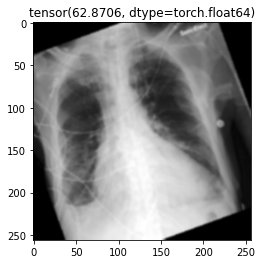

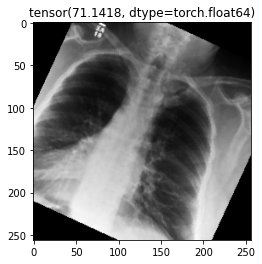

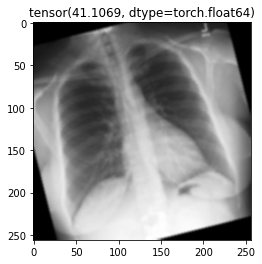

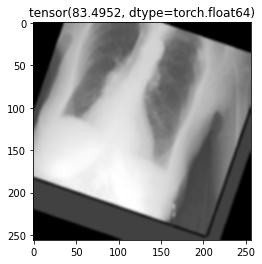

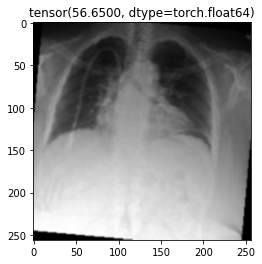

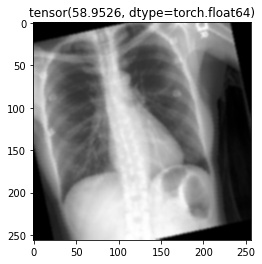

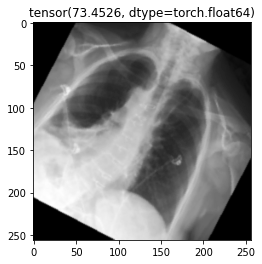

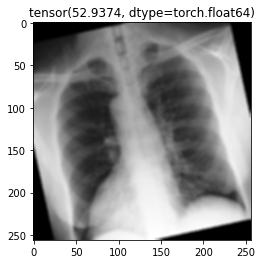

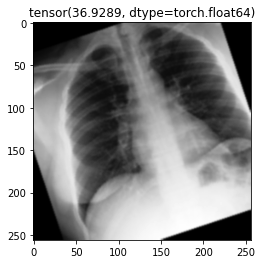

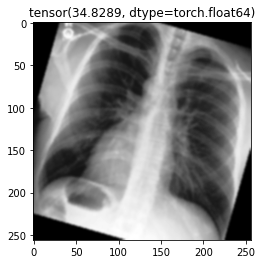

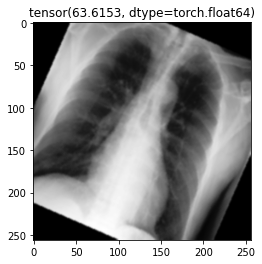

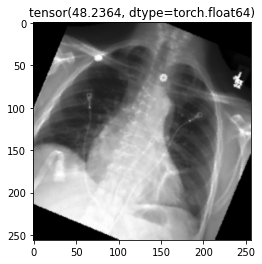

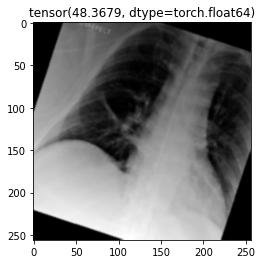

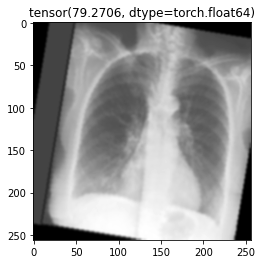

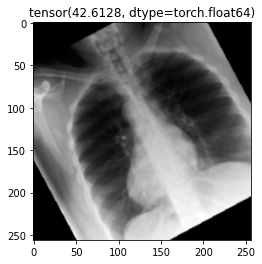

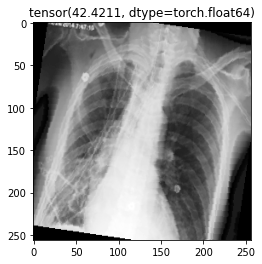

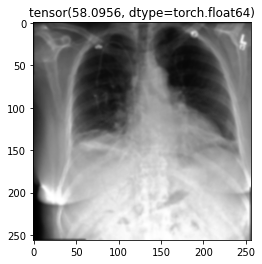

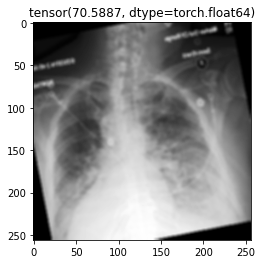

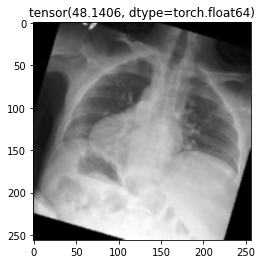

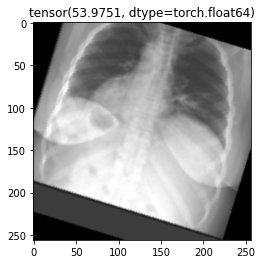

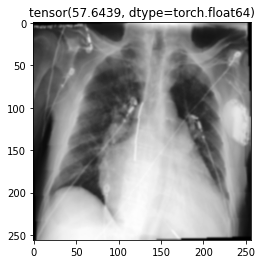

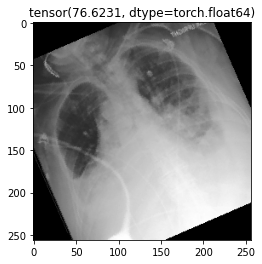

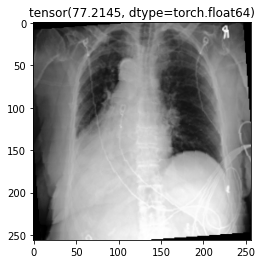

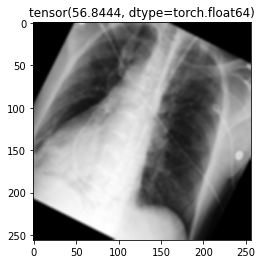

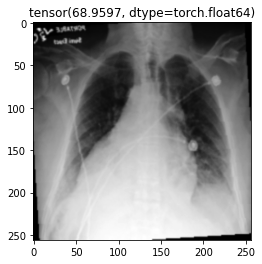

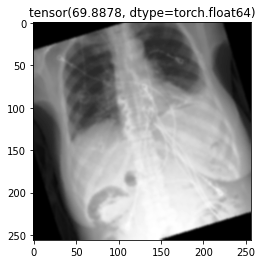

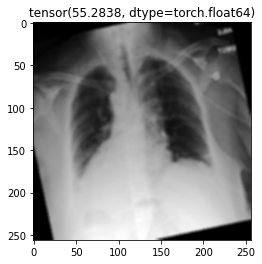

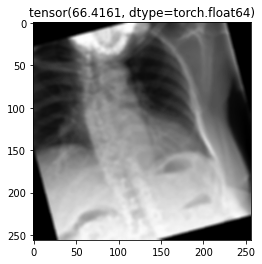

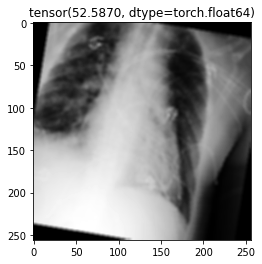

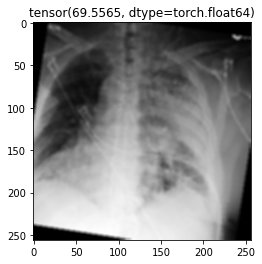

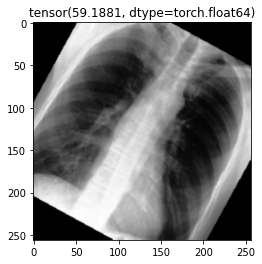

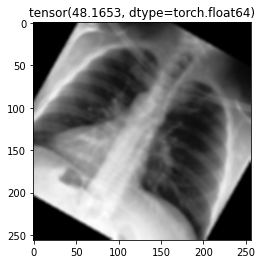

Batch:   0%|          | 0/17125 [00:33<?, ?it/s]


In [8]:
for batch in tqdm.tqdm(dataloader, desc="Batch"):
    imgs = batch['img']
    targets = batch['target']
    for img, target in zip(imgs, targets):
        plt.imshow(img[0, :, :], cmap="gray")
        plt.title(target)
        plt.show()
        
    break